# Parkinson Disease Detection from Audio using Deep Learning Techniques

## Imports

In [ ]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Reshape, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras_tuner import Hyperband
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

## Reading and Converting Data to MFCCs

In [2]:
parkinson_dir = "train_data/parkinson"
healthy_dir = "train_data/healthy"

parkinson_dir_test = "test_data/parkinson"
healthy_dir_test = "test_data/healthy"


def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=100, hop_length=50)
    return mfcc


def load_data_from_dir(folder):
    mfccs = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder, filename)
            mfcc = extract_mfcc(file_path)
            mfccs.append(mfcc)
            labels.append(1 if "parkinson" in folder else 0)
    return mfccs, labels


parkinson_mfccs, parkinson_labels = load_data_from_dir(parkinson_dir)
healthy_mfccs, healthy_labels = load_data_from_dir(healthy_dir)

parkinson_mfccs_test, parkinson_labels_test = load_data_from_dir(parkinson_dir_test)
healthy_mfccs_test, healthy_labels_test = load_data_from_dir(healthy_dir_test)

c:\Users\tailw\DataWorks\Parkinson Disease Detection\.venv\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [3]:
min_length = min(min(mfcc.shape[1] for mfcc in parkinson_mfccs), min(mfcc.shape[1] for mfcc in healthy_mfccs))

def truncate_mfccs(parkinson_mfccs, healthy_mfccs):
    return [mfcc[:, :min_length] for mfcc in parkinson_mfccs], [mfcc[:, :min_length] for mfcc in healthy_mfccs] 


parkinson_mfccs, healthy_mfccs = truncate_mfccs(parkinson_mfccs, healthy_mfccs)
parkinson_mfccs_test, healthy_mfccs_test = truncate_mfccs(parkinson_mfccs_test, healthy_mfccs_test)


X_train = np.concatenate((parkinson_mfccs, healthy_mfccs), axis=0)
y_train = np.concatenate((parkinson_labels, healthy_labels), axis=0)

X_test = np.concatenate((parkinson_mfccs_test, healthy_mfccs_test), axis=0)
y_test = np.concatenate((parkinson_labels_test, healthy_labels_test), axis=0)

## Preparing Data for Deep Learning Model

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((81, 13, 243), (81,), (20, 13, 243), (20,))

In [5]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((81, 13, 243, 1), (81,), (20, 13, 243, 1), (20,))

## Deep Learning Modeling and Evaluation

### ANN Model

In [42]:
X_train_ann = X_train.reshape(81, 13 * 243)
X_test_ann = X_test.reshape(20, 13 * 243)

In [196]:
def build_model(hp):
    model = Sequential()

    model.add(Input(shape=(13 * 243,)))

    for i in range(hp.Int('num_layers', 1, 5)):

        model.add(Dense(hp.Int(f'units_{i}', min_value=64, max_value=512, step=32), activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [207]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='tuners',
    project_name='ann_tuners'
)

tuner.search(X_train_ann, y_train, validation_data=(X_test_ann, y_test))

Reloading Tuner from tuners\ann_tuners\tuner0.json


In [208]:
ann = tuner.get_best_models(num_models=1)[0]
ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 288)            │       910,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 384)            │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,021,441 (3.90 MB)

 Trainable params: 1,021,441 (3.90 MB)

 Non-trainable params: 0 (0.00 B)

In [209]:
history = ann.fit(X_train_ann, y_train, epochs=15, validation_data=(X_test_ann, y_test))

Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.6921 - loss: 67.2819 - val_accuracy: 0.5000 - val_loss: 51.4846
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4813 - loss: 57.4206 - val_accuracy: 0.5000 - val_loss: 44.1009
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5086 - loss: 42.7578 - val_accuracy: 0.5000 - val_loss: 19.4564
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5161 - loss: 24.5446 - val_accuracy: 0.5000 - val_loss: 15.8844
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4891 - loss: 13.9634 - val_accuracy: 0.5500 - val_loss: 3.3712
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5457 - loss: 7.5905 - val_accuracy: 0.7000 - val_loss: 2.8647
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5847 - loss: 4.8122 - val_accuracy: 0.8000 - val_loss: 1.6741
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7067 - loss: 4.0621 - val_accuracy: 0.9500 - val_los

In [210]:
ann.save("models/ann.keras")

### Model Evaluation

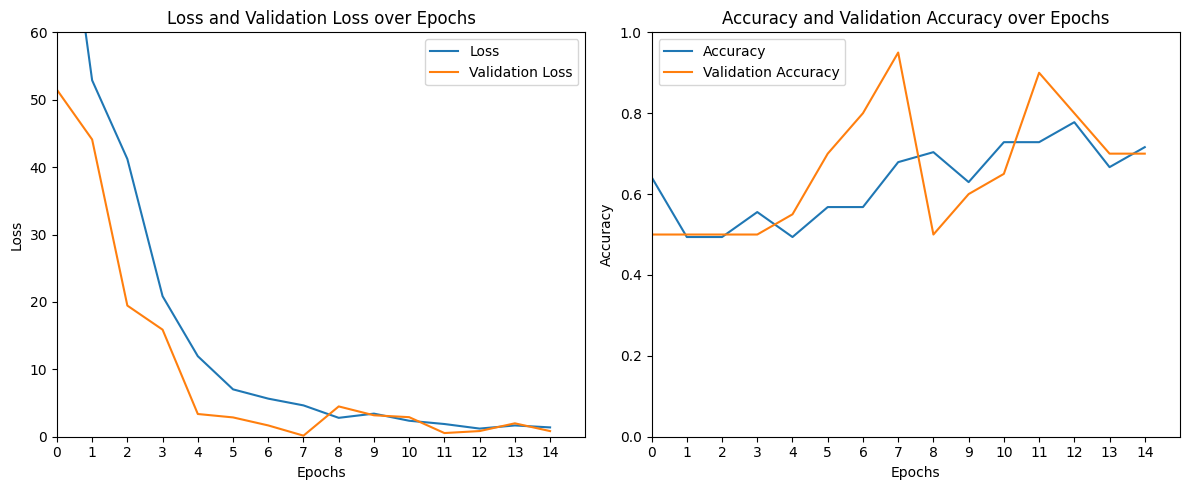

In [211]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss and Validation Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 60)
ax1.set_xlim(0, 15)
ax1.set_xticks(np.arange(0, 15, 1))
ax1.legend()

ax2.plot(history.history['accuracy'], label='Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy and Validation Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.set_xlim(0, 15)
ax2.set_xticks(np.arange(0, 15, 1))
ax2.legend()

plt.tight_layout()
plt.show()

In [212]:
fig.savefig('models/ann_accuracy_loss_plots.png')

In [43]:
ann = load_model("models/ann.keras")

y_train_pred = (ann.predict(X_train_ann) > 0.5).astype("int32")
y_test_pred = (ann.predict(X_test_ann) > 0.5).astype("int32")

ann_train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
ann_train_accuracy = round(accuracy_score(y_train, y_train_pred), 2)
ann_train_recall = round(recall_score(y_train, y_train_pred), 2)
ann_train_precision = round(precision_score(y_train, y_train_pred), 2)
ann_train_f1 = round(f1_score(y_train, y_train_pred), 2)

ann_test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
ann_test_accuracy = round(accuracy_score(y_test, y_test_pred), 2)
ann_test_recall = round(recall_score(y_test, y_test_pred), 2)
ann_test_precision = round(precision_score(y_test, y_test_pred), 2)
ann_test_f1 = round(f1_score(y_test, y_test_pred), 2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


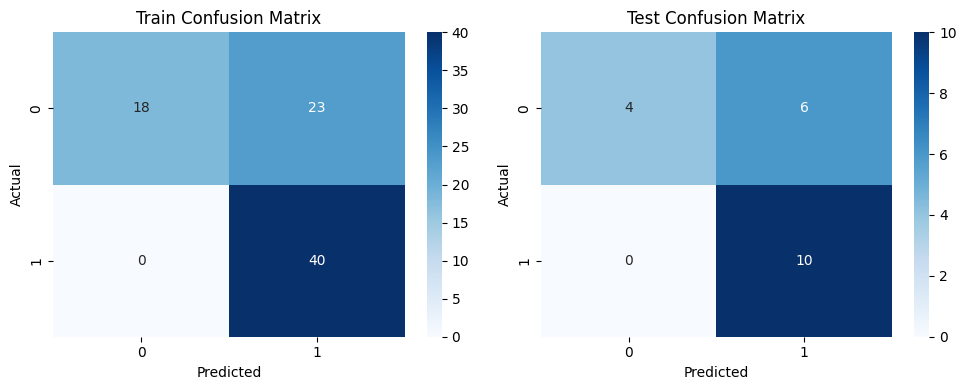

In [219]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(ann_train_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(ann_test_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [215]:
fig.savefig('models/ann_confusion_matrix.png')

### CNN Model

In [171]:
def build_model(hp):
    model = Sequential()
    
    model.add(Input(shape=(13, 243, 1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Conv2D(
            filters=hp.Int('conv_1_filters', min_value=8, max_value=24, step=4),
            padding='same',
            kernel_size=(3, 3),
            activation='relu',
        ))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [172]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='tuners',
    project_name='cnn_tuners'
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test))

Reloading Tuner from tuners\cnn_tuners\tuner0.json


In [173]:
cnn = tuner.get_best_models(num_models=1)[0]
cnn.summary()

c:\Users\tailw\DataWorks\Parkinson Disease Detection\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 243, 12)    │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 121, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 121, 12)     │         1,308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 60, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 60, 12)      │         1,308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 30, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        46,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,073 (191.69 KB)

 Trainable params: 49,073 (191.69 KB)

 Non-trainable params: 0 (0.00 B)

In [174]:
history = cnn.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6524 - loss: 2.7247 - val_accuracy: 0.5500 - val_loss: 0.8705
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5707 - loss: 1.4058 - val_accuracy: 0.5000 - val_loss: 1.1908
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6608 - loss: 0.7241 - val_accuracy: 0.5000 - val_loss: 1.0543
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6240 - loss: 0.7797 - val_accuracy: 0.6000 - val_loss: 0.9643
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6793 - loss: 0.6766 - val_accuracy: 0.7000 - val_loss: 0.7328
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7158 - loss: 0.5477 - val_accuracy: 0.6500 - val_loss: 0.5794
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6995 - loss: 0.5103 - val_accuracy: 0.7000 - val_loss: 0.5463
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8169 - loss: 0.4317 - val_accuracy: 0.7500 - val_loss: 0.6177

In [175]:
cnn.save("models/cnn.keras")

### Model Evaluation

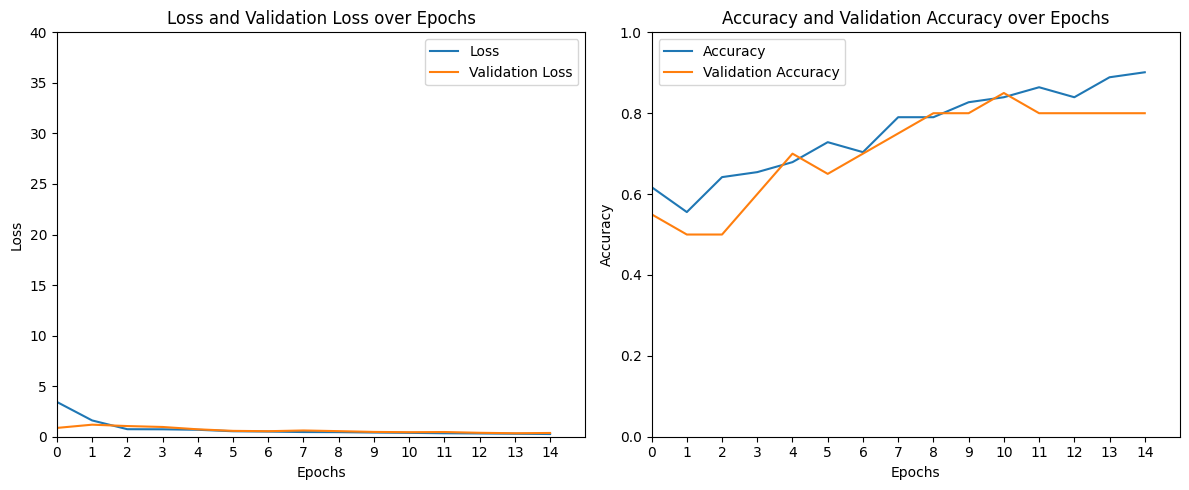

In [176]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss and Validation Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 40)
ax1.set_xlim(0, 15)
ax1.set_xticks(np.arange(0, 15, 1))
ax1.legend()

ax2.plot(history.history['accuracy'], label='Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy and Validation Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.set_xlim(0, 15)
ax2.set_xticks(np.arange(0, 15, 1))
ax2.legend()

plt.tight_layout()
plt.show()

In [177]:
fig.savefig('models/cnn_accuracy_loss_plots.png')

In [44]:
cnn = load_model("models/cnn.keras")

y_train_pred = (cnn.predict(X_train) > 0.5).astype("int32")
y_test_pred = (cnn.predict(X_test) > 0.5).astype("int32")

cnn_train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
cnn_train_accuracy = round(accuracy_score(y_train, y_train_pred), 2)
cnn_train_recall = round(recall_score(y_train, y_train_pred), 2)
cnn_train_precision = round(precision_score(y_train, y_train_pred), 2)
cnn_train_f1 = round(f1_score(y_train, y_train_pred), 2)

cnn_test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
cnn_test_accuracy = round(accuracy_score(y_test, y_test_pred), 2)
cnn_test_recall = round(recall_score(y_test, y_test_pred), 2)
cnn_test_precision = round(precision_score(y_test, y_test_pred), 2)
cnn_test_f1 = round(f1_score(y_test, y_test_pred), 2)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000019E806CF9A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


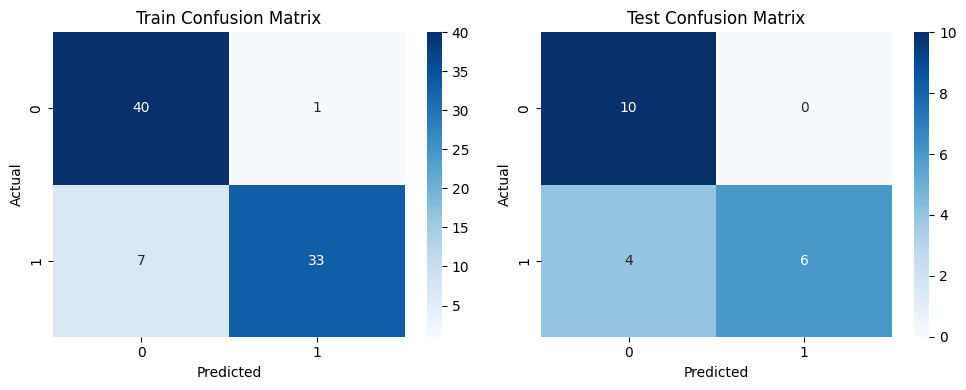

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(cnn_train_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cnn_test_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [180]:
fig.savefig('models/cnn_confusion_matrix.png')

### CNN-LSTM Model

In [26]:
def build_model(hp):
    layer_count = 0
    model = Sequential()
    
    model.add(Input(shape=(13, 243, 1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Conv2D(
            hp.Int(f'filters_{i}', min_value=8, max_value=32, step=4),
            (3, 3),
            padding='same',
            activation='relu'
        ))
        layer_count += 1
    
    model.add(Reshape((-1, 243)))
    layer_count += 1

    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(LSTM(
            hp.Int(f'lstm_units_{layer_count + i}', min_value=8, max_value=32, step=4),
            return_sequences=True
        ))
        layer_count += 1
    
    model.add(LSTM(
        hp.Int(f'lstm_units{layer_count}', min_value=8, max_value=32, step=4),
        return_sequences=False
    ))

    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='tuners',
    project_name='hybrid_tuners'
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test))

Trial 8 Complete [00h 00m 08s]
val_accuracy: 0.75

Best val_accuracy So Far: 0.75
Total elapsed time: 00h 12m 24s


In [30]:
hybrid = tuner.get_best_models(num_models=1)[0]
hybrid.summary()

c:\Users\tailw\DataWorks\Parkinson Disease Detection\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 243, 24)    │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 312, 243)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 312, 24)        │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20)             │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,385 (126.50 KB)

 Trainable params: 32,385 (126.50 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = hybrid.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - accuracy: 0.5522 - loss: 0.6914 - val_accuracy: 0.5500 - val_loss: 0.6811
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5658 - loss: 0.6774 - val_accuracy: 0.6000 - val_loss: 0.6553
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7431 - loss: 0.6402 - val_accuracy: 0.7500 - val_loss: 0.6179
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7577 - loss: 0.6076 - val_accuracy: 0.7500 - val_loss: 0.5941
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7600 - loss: 0.5611 - val_accuracy: 0.6500 - val_loss: 0.5991
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7337 - loss: 0.5600 - val_accuracy: 0.7500 - val_loss: 0.4937
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8159 - loss: 0.4540 - val_accuracy: 0.8500 - val_loss: 0.3965
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8696 - loss: 0.3360 - val_accuracy: 0.9000 - val_loss:

In [32]:
hybrid.save("models/hybrid.keras")

### Model Evaluation

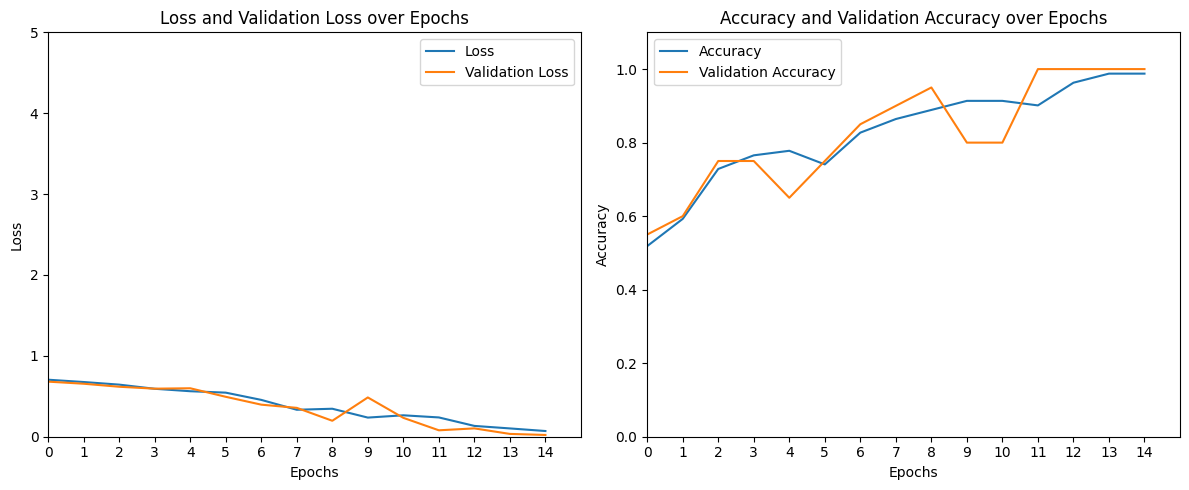

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss and Validation Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 5)
ax1.set_xlim(0, 15)
ax1.set_xticks(np.arange(0, 15, 1))
ax1.legend()

ax2.plot(history.history['accuracy'], label='Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy and Validation Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1.1)
ax2.set_xlim(0, 15)
ax2.set_xticks(np.arange(0, 15, 1))
ax2.legend()

plt.tight_layout()
plt.show()

In [34]:
fig.savefig('models/hybrid_accuracy_loss_plots.png')

In [52]:
hybrid = load_model("models/hybrid.keras")

y_train_pred = (hybrid.predict(X_train) > 0.5).astype("int32")
y_test_pred = (hybrid.predict(X_test) > 0.5).astype("int32")

hybrid_train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
hybrid_train_accuracy = round(accuracy_score(y_train, y_train_pred), 2)
hybrid_train_recall = round(recall_score(y_train, y_train_pred), 2)
hybrid_train_precision = round(precision_score(y_train, y_train_pred), 2)
hybrid_train_f1 = round(f1_score(y_train, y_train_pred), 2)

hybrid_test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
hybrid_test_accuracy = round(accuracy_score(y_test, y_test_pred), 2)
hybrid_test_recall = round(recall_score(y_test, y_test_pred), 2)
hybrid_test_precision = round(precision_score(y_test, y_test_pred), 2)
hybrid_test_f1 = round(f1_score(y_test, y_test_pred), 2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


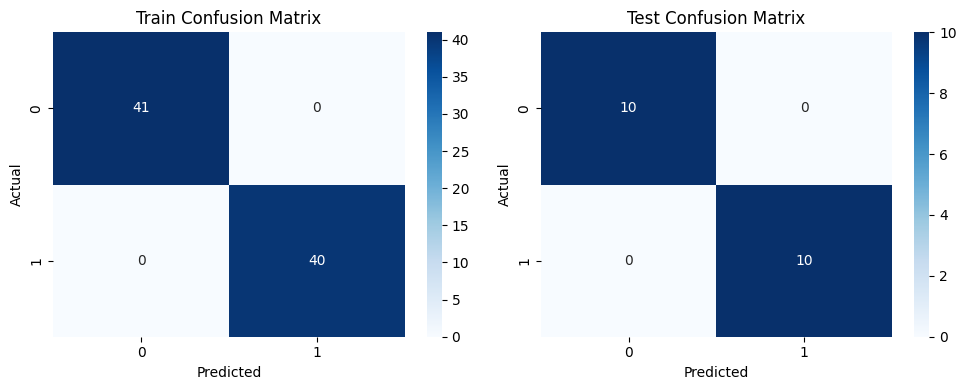

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(hybrid_train_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(hybrid_test_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [39]:
fig.savefig('models/hybrid_confusion_matrix.png')

## Comparison

In [49]:
import pandas as pd


data = {
    'Model': ['ANN', 'CNN', 'Hybrid'],
    'Train Accuracy': [ann_train_accuracy, cnn_train_accuracy, hybrid_train_accuracy],
    'Test Accuracy': [ann_test_accuracy, cnn_test_accuracy, hybrid_test_accuracy],
    'Train Precision': [ann_train_precision, cnn_train_precision, hybrid_train_precision],
    'Test Precision': [ann_test_precision, cnn_test_precision, hybrid_test_precision],
    'Train Recall': [ann_train_recall, cnn_train_recall, hybrid_train_recall],
    'Test Recall': [ann_test_recall, cnn_test_recall, hybrid_test_recall],
    'Train F1 Score': [ann_train_f1, cnn_train_f1, hybrid_train_f1],
    'Test F1 Score': [ann_test_f1, cnn_test_f1, hybrid_test_f1]
}

df = pd.DataFrame(data)
df


,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train F1 Score,Test F1 Score
0,ANN,0.72,0.7,0.63,0.62,1.00,1.0,0.78,0.77
1,CNN,0.90,0.8,0.97,1.00,0.82,0.6,0.89,0.75
2,Hybrid,1.00,1.0,1.00,1.00,1.00,1.0,1.00,1.00


In [53]:
df.to_csv('model_performance_comparison.csv', index=False)